# GCAM visualization tutorial: `rchart`
## Taryn Waite

# Visualizing GCAM outputs
GCAM has many complex outputs spanning scenarios, regions, and years, as well as query-specific dimensions such as sectors, fuels, emissions species, land types, and more. The R package `rchart` is designed to help users quickly produce the types of charts that are commonly used to visualize GCAM outputs across these dimensions. This notebook demonstrates a selection of `rchart` features; a more comprehensive [user guide](https://jgcri.github.io/rchart/articles/vignette_userguide.html) is available on GitHub.  

## Input formats
Before using `rchart`, you will need to make sure that your GCAM output data is in the right format. Your data should be an R data frame containing at least the following columns:

- `subRegion`: GCAM region(s)
- `year`: GCAM periods
- `value`: data values

`rchart` can also utilize additional columns including:

- `param`: if your data includes multiple queries (e.g., population and GDP)
- `scenario`: if your data includes multiple scenarios
- `class`: if your data contains multiple categories, such as sectors, fuels, land types, etc.

In this demonstration, we will start from a selection of `rgcam` outputs. First, we use `rgcam` to extract a few queries of interest (population, GDP, electricity generation, and final energy consumption):

In [1]:
library(rgcam)
host <- "localhost"
conn <- remoteDBConn('gcamv71_training_basexdb', 'training', 'training', host)
prj <- addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM")
prj <- addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM_SSP3")

Database scenarios:  GCAM, GCAM_SSP3

Warning message in addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM"):
“Skipping running query population by region since clobber is false and already exists in project.”
Warning message in addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM"):
“Skipping running query GDP MER by region since clobber is false and already exists in project.”
Warning message in addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM"):
“Skipping running query elec gen by subsector since clobber is false and already exists in project.”
Warning message in addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM"):
“Skipping running query final energy consumption by fuel since clobber is false and already exists in project.”
Warning message in addScenario(conn, "prj", queryFile = "../data/queries.xml", scenario = "GCAM"):
“Skipping running query detailed land allocation since cl

In [2]:
pop <- getQuery(prj, 'population by region')
gdp <- getQuery(prj, 'GDP MER by region')
elec_gen <- getQuery(prj, 'elec gen by subsector')
final_en <- getQuery(prj, 'final energy consumption by fuel')


We can take a look at the existing columns in our data:

In [3]:
head(pop)
head(gdp)
head(elec_gen)
head(final_en)

Units scenario region         year value 
1 thous GCAM     Africa_Eastern 1975  91890
2 thous GCAM     Africa_Eastern 1990 145593
3 thous GCAM     Africa_Eastern 2005 222829
4 thous GCAM     Africa_Eastern 2010 255333
5 thous GCAM     Africa_Eastern 2015 292560
6 thous GCAM     Africa_Eastern 2020 327652

Units         scenario region         year account value 
1 million 1990$ GCAM     Africa_Eastern 1975 GDP      28893
2 million 1990$ GCAM     Africa_Eastern 1990 GDP      46850
3 million 1990$ GCAM     Africa_Eastern 2005 GDP      85953
4 million 1990$ GCAM     Africa_Eastern 2010 GDP     119402
5 million 1990$ GCAM     Africa_Eastern 2015 GDP     151679
6 million 1990$ GCAM     Africa_Eastern 2020 GDP     187112

Units scenario region         subsector year value     
1 EJ    GCAM     Africa_Eastern biomass   1990 0.00129301
2 EJ    GCAM     Africa_Eastern biomass   2005 0.00210229
3 EJ    GCAM     Africa_Eastern biomass   2010 0.00273200
4 EJ    GCAM     Africa_Eastern biomass   2015 0.00243691
5 EJ    GCAM     Africa_Eastern biomass   2020 0.00435397
6 EJ    GCAM     Africa_Eastern biomass   2025 0.01075513

Units scenario region         input   year value    
1 EJ    GCAM     Africa_Eastern biomass 1975 0.2831986
2 EJ    GCAM     Africa_Eastern biomass 1990 0.6470327
3 EJ    GCAM     Africa_Eastern biomass 2005 0.9775412
4 EJ    GCAM     Africa_Eastern biomass 2010 1.0692006
5 EJ    GCAM     Africa_Eastern biomass 2015 1.2280636
6 EJ    GCAM     Africa_Eastern biomass 2020 1.3045274

Next, we will do some  post-processing to get the data ready for use in `rchart` and combine the queries into a single dataframe, using a new `param` column to differentiate between queries. We also need to add a `class` column corresponding with the category of interest in our data; for data without a categorical variable (population and gdp), we just need to add a placeholder `class` column. Finally, we will need to add a `subRegion` column, which will have the same values as `region`.

In [4]:
# load libraries needed for post-processing
library(dplyr)
library(magrittr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
pop1 <- pop %>%
    mutate(subRegion = region,
           class = "class",
           param = "population")

gdp1 <- gdp %>%
    select(-account) %>%
    mutate(subRegion = region,
           class = "class",
           param = "gdp")

elec_gen1 <- elec_gen %>%
    rename(class = subsector) %>%
    mutate(subRegion = region,
           param = "elec gen")

final_en1 <- final_en %>%
    rename(class = input) %>%
    mutate(subRegion = region,
           param = "final energy")

# let's filter to only a couple regions to save time
all_data <- rbind(pop1, gdp1, elec_gen1, final_en1) %>%
    filter(region %in% c("USA", "India"))


## Generate charts
Once our data is in the correct format, we can use `rchart`'s `chart()` function to automatically generate a selection of charts summarizing the data. The only necessary argument is `data`. The function returns a list of `ggplot` chart objects and by default, the charts are also saved as `.png` files in the working directory. To turn off this feature, we can set `save = F` as shown below. Alternatively, the `folder` argument can be used to change the location where the charts are saved.

In [6]:
library(rchart)

In [7]:
my_charts <- chart(all_data,
                   save = F)

[1] "Starting chart..."
[1] "Completed chart."


The list returned by the `chart` function includes line charts of parameter totals (these have names starting with "chart_param" as well as bar charts showing values by class (these have names starting with chart_class).

In [8]:
print(names(my_charts))

[1] "chart_param_India"     "chart_class_India"     "chart_param_USA"      
[4] "chart_class_USA"       "chart_class_GCAM"      "chart_class_GCAM_SSP3"
[7] "chart_region_absolute"


The individual charts can be accessed using the `$` operator as shown in the below sections.

### Line charts (absolute values)
These line charts showing the total values of each `param`. A chart is generated for each `region` showing each `param` in a separate panel with colors corresponding with `scenario`:

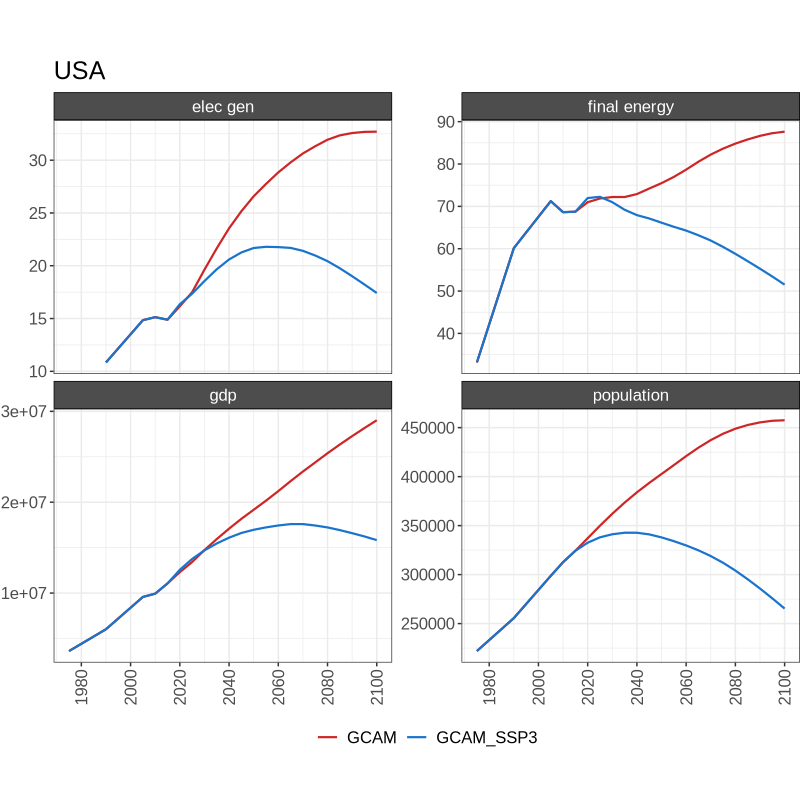

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)
my_charts$chart_param_USA 

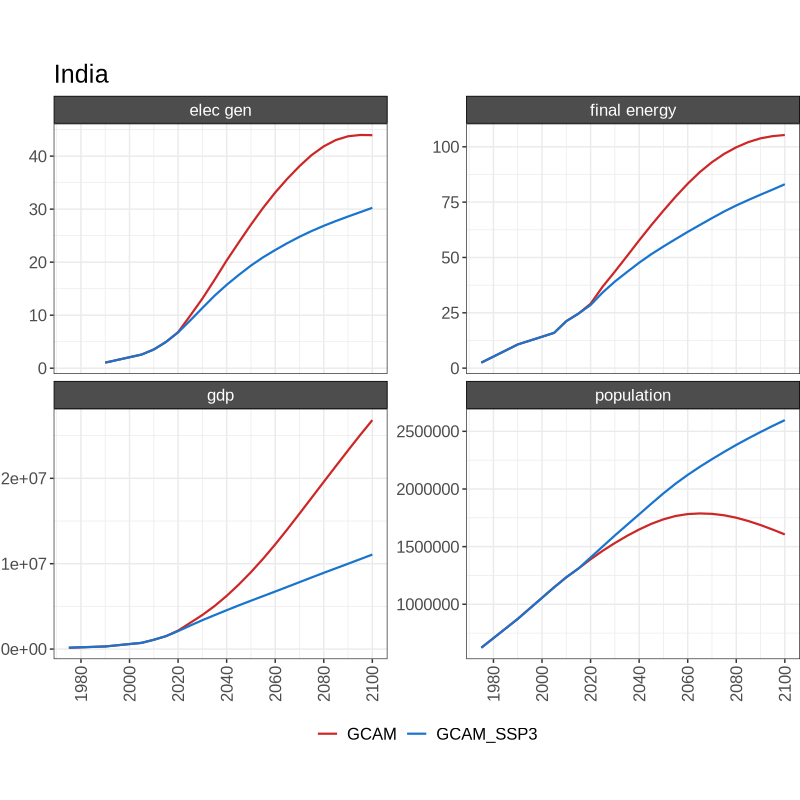

In [10]:
my_charts$chart_param_India

A chart is also generated showing each `param`-`scenario` combination with colors corresponding to `region`:

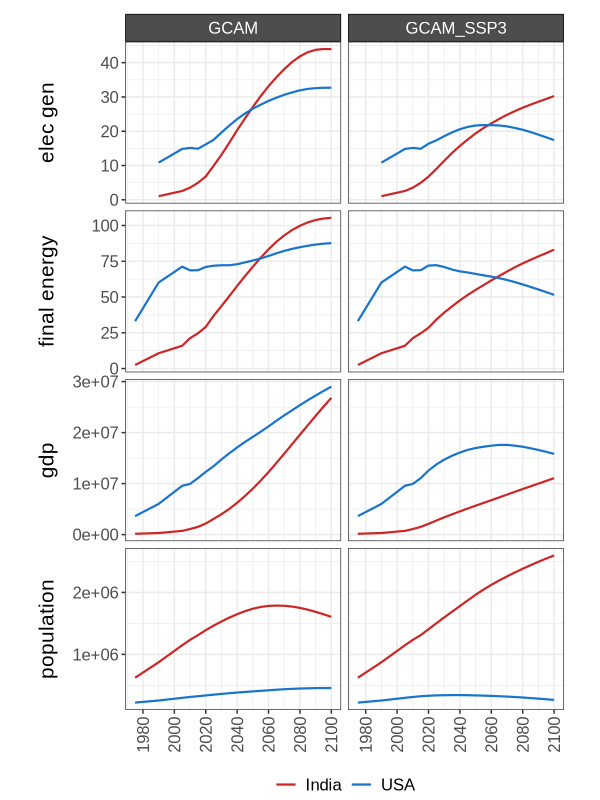

In [11]:
options(repr.plot.width = 6, repr.plot.height = 8, repr.plot.res = 100)
my_charts$chart_region_absolute

### Bar charts (absolute values)
`rchart` also generates stacked bar charts showing the data by `class`. These charts have a row for each `param` and columns corresponding to either `scenario` or `region`. Since the population and gdp parameters don't have a meaningful `class` column, we will regenerate the charts using only the electricity generation and final energy consumption parameters before viewing the bar charts. Note that the `chart_type` argument can be used to specify which charts to generate, rather than generating the full set.

In [12]:
data_barcharts <- all_data %>%
    filter(param %in% c("elec gen", "final energy"))

my_charts <- chart(data_barcharts,
                    save = F,
                    chart_type = "class_absolute")

[1] "Starting chart..."
[1] "Completed chart."


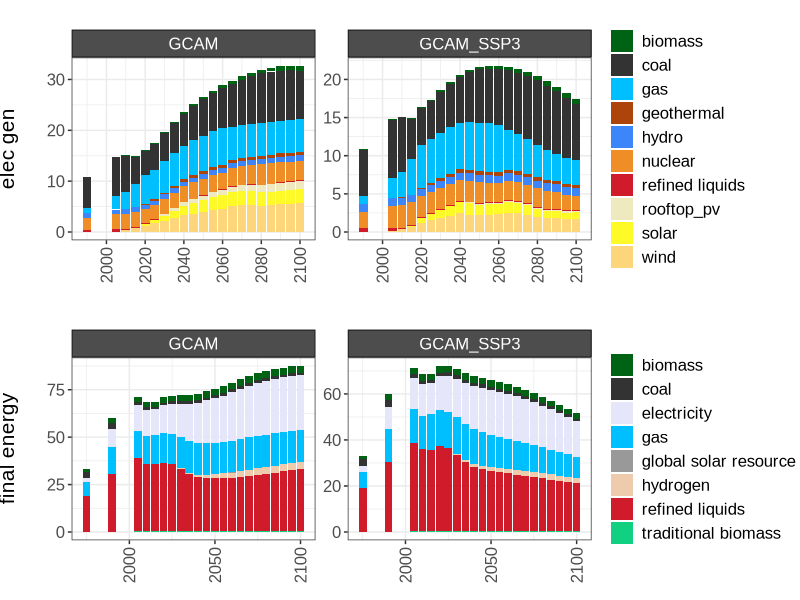

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 100)
my_charts$chart_class_USA

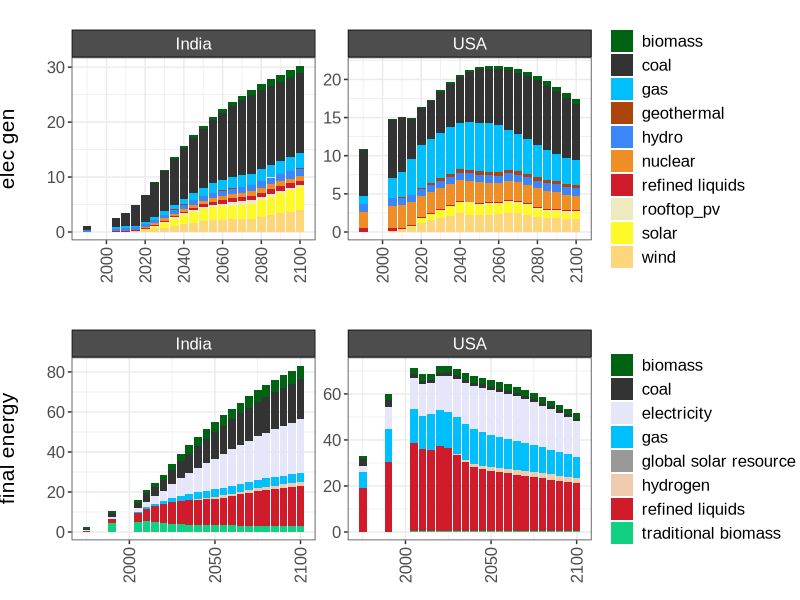

In [14]:
my_charts$chart_class_GCAM_SSP3

### Line charts (scenario differences)
In the `chart()` function, we can also define the "reference" scenario to which we want to compare other scenarios. If a "reference" scenario is specified using the `scenRef` argument, then line and bar charts are also generated to compare each additional scenario with the reference scenario. These include both absolute differences and percent differences.

In [15]:
my_charts <- chart(all_data,
                   scenRef = "GCAM",
                   save = F)

[1] "Starting chart..."
[1] "Completed chart."


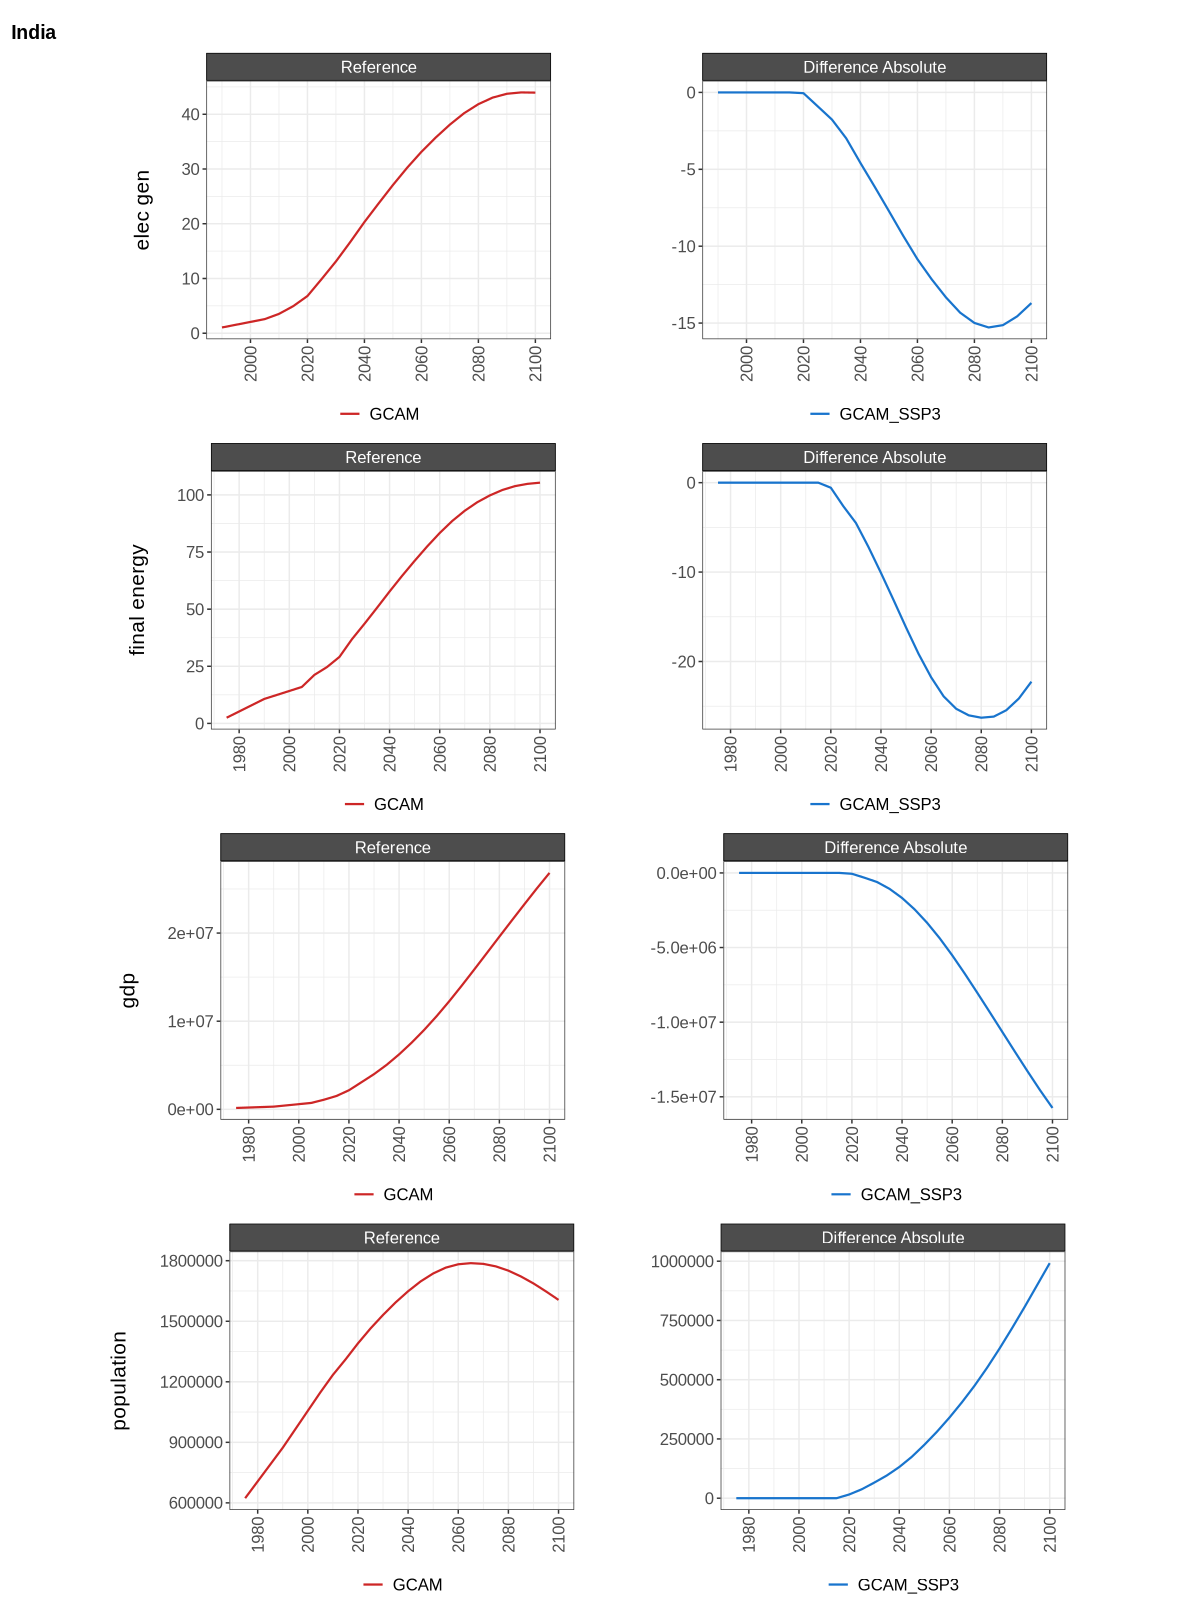

In [16]:
options(repr.plot.width = 12, repr.plot.height = 16, repr.plot.res = 100)
my_charts$chart_param_diff_absolute_India

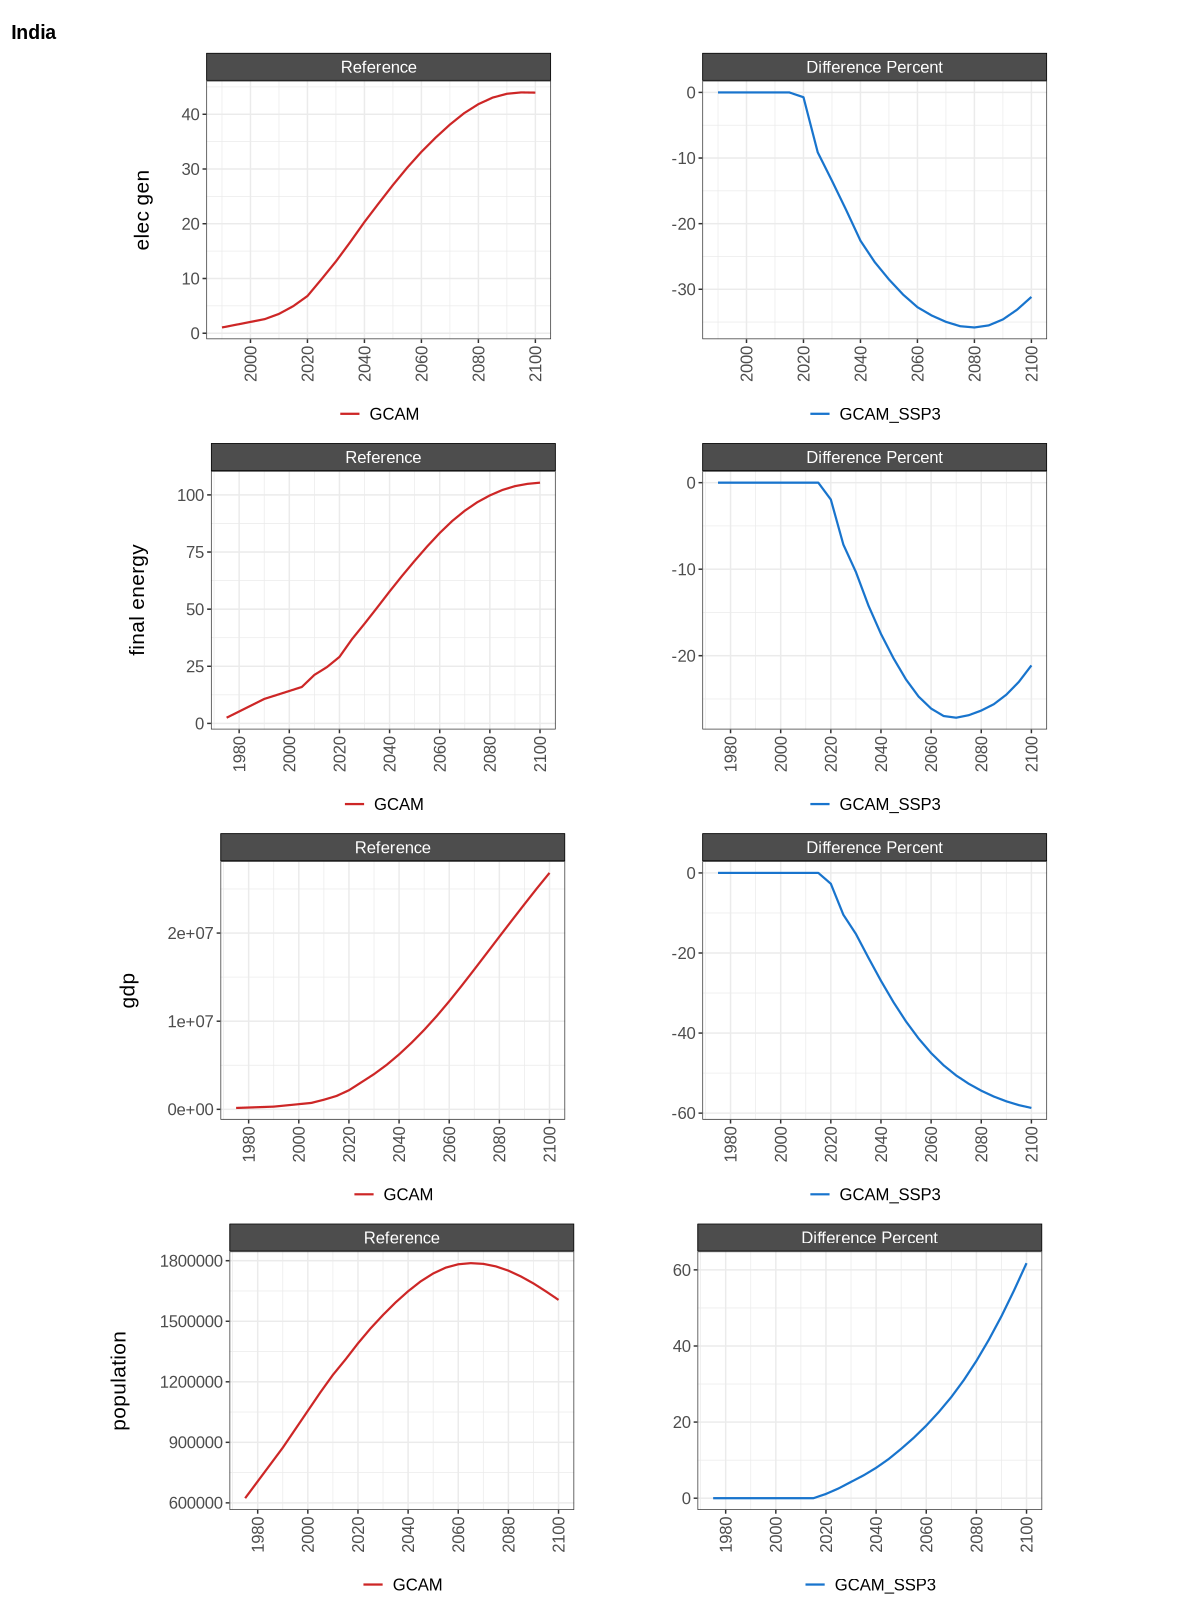

In [17]:
my_charts$chart_param_diff_percent_India

### Bar charts (scenario differences)
As with the line charts, `rchart` also generates bar charts showing the differences by `class` between `scenRef` and each additional scenario. As with the previous bar charts, we'll generate these using a subset of the data that has a meaningful `class` column.

In [18]:
my_charts <- chart(data_barcharts,
                   scenRef = "GCAM",
                   save = F)

[1] "Starting chart..."
[1] "Completed chart."


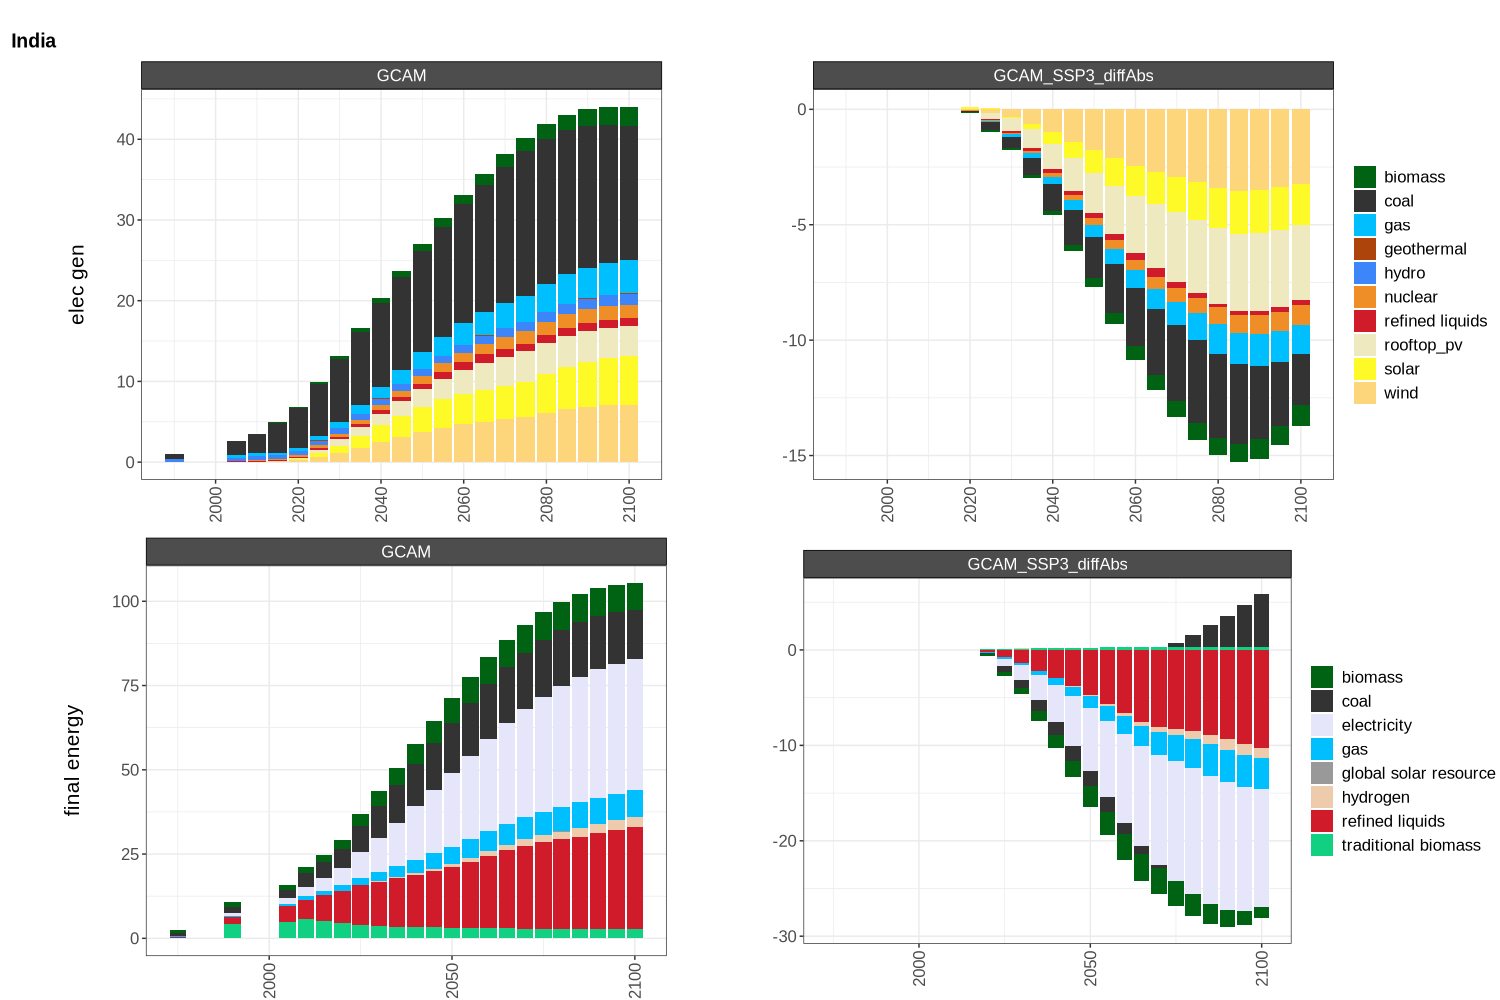

In [19]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
my_charts$chart_class_diff_absolute_India

As well as combined bar-line charts showing the percent differences by `class`:

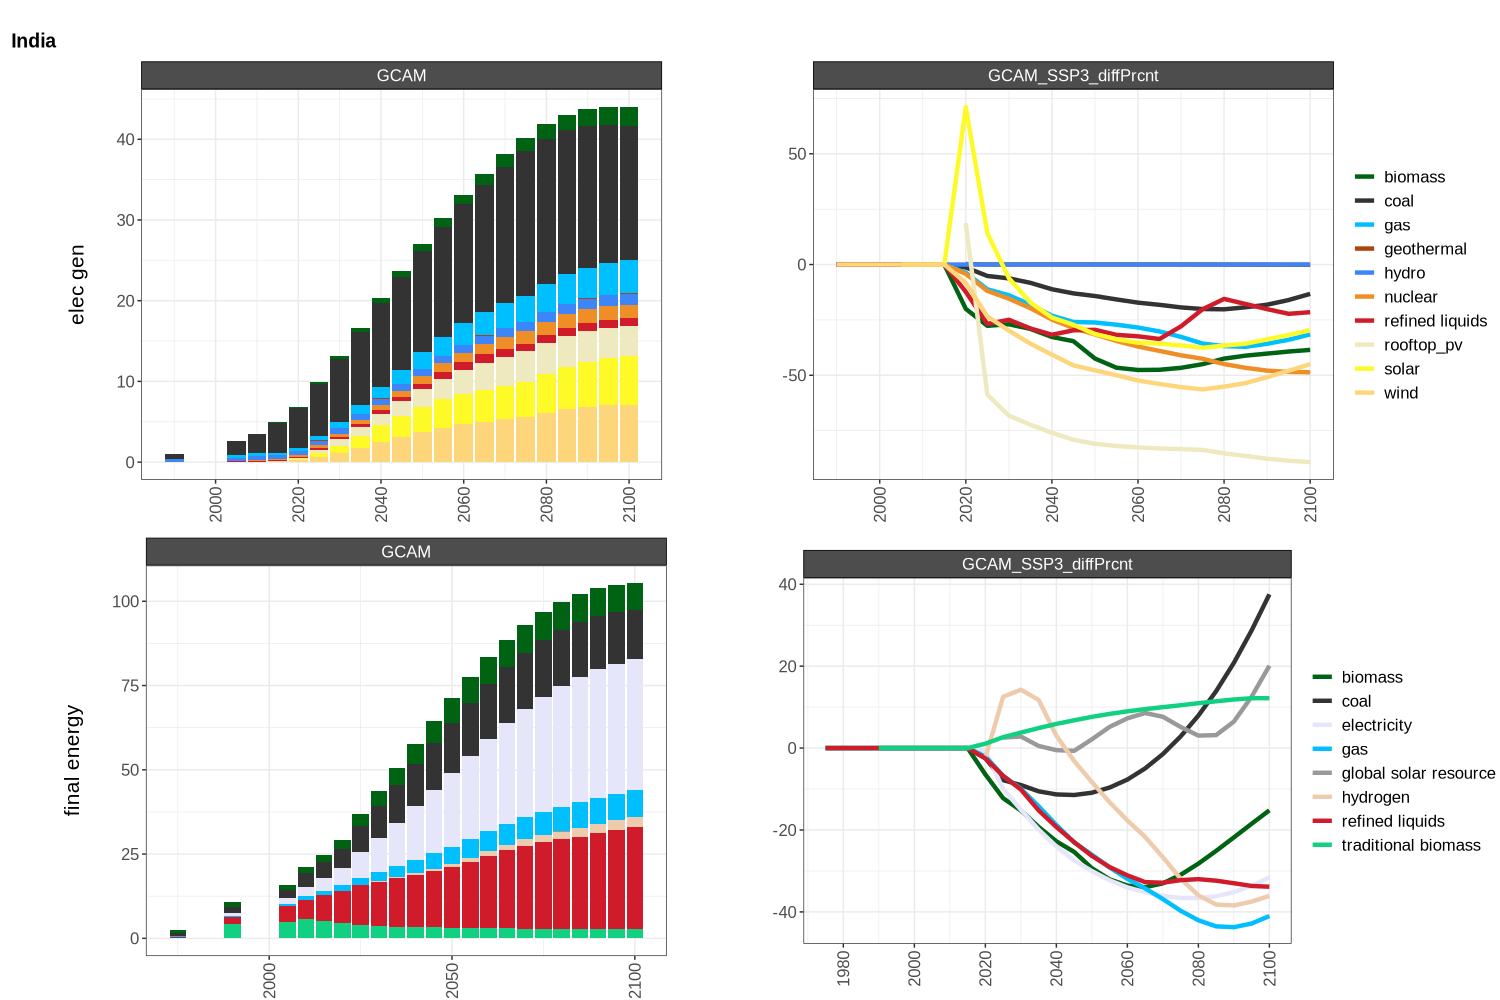

In [20]:
my_charts$chart_class_diff_percent_India

### Waterfall charts
Finally, when a `scenRef` is specified, `rchart` generates waterfall charts showing a snapshot of the `class`-wise differences between scenarios in a single year. By default, `rchart` uses the latest year in the dataframe for waterfall charts, but a different year can be passed to the `chart()` function using the `waterfall_x` argument if desired. 

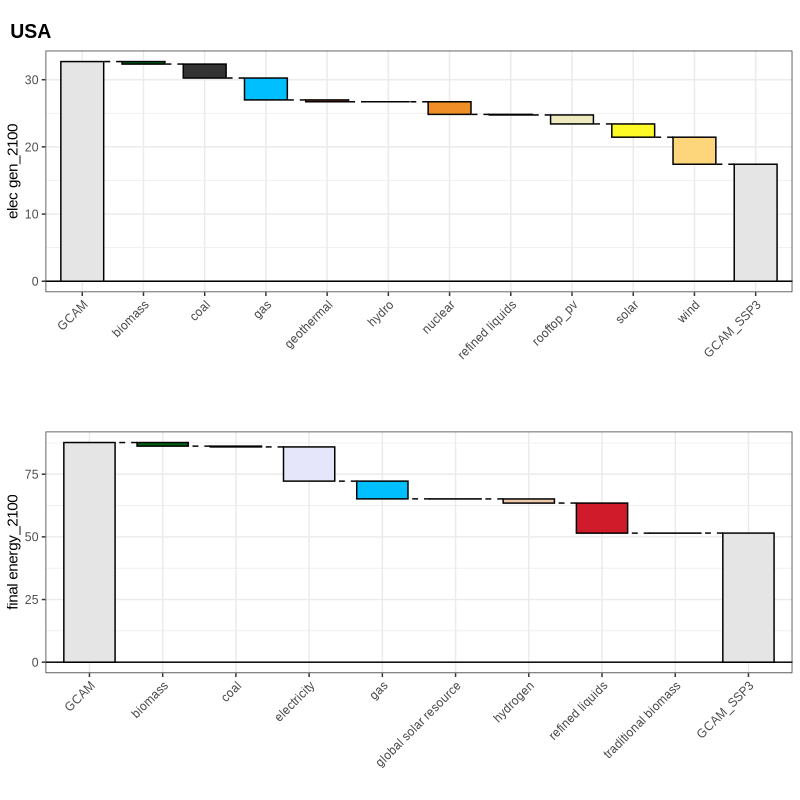

In [21]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)
my_charts$chart_class_waterfall_USA

[1] "Starting chart..."
[1] "Completed chart."


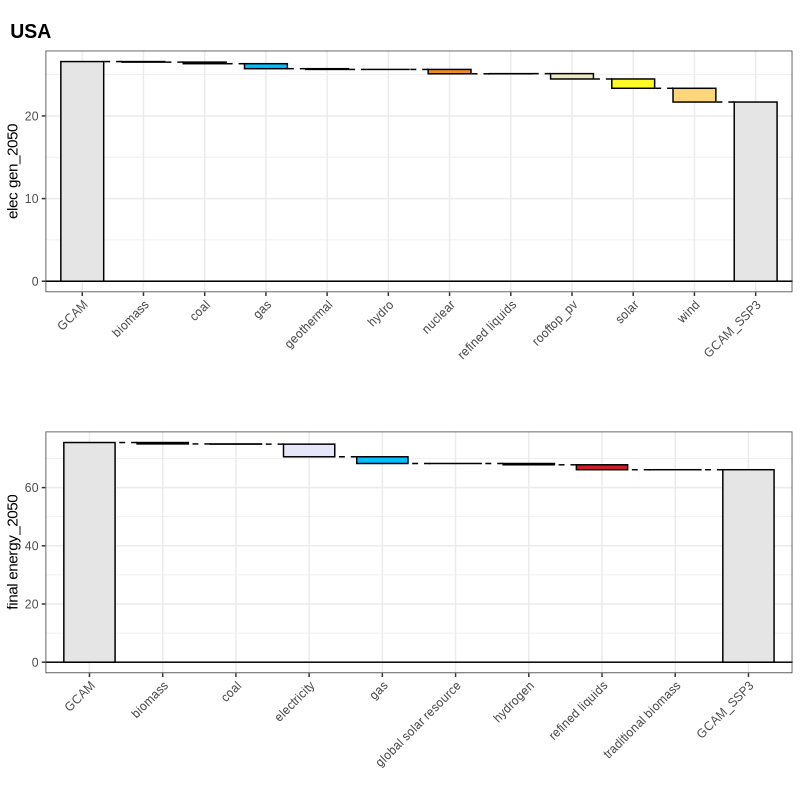

In [22]:
my_charts <- chart(data_barcharts,
                    scenRef = "GCAM",
                    save = F,
                    waterfall_x = 2050)

my_charts$chart_class_waterfall_USA

## Customization options
The `chart()` function has several additional arguments to further customize your charts.

### Custom color palettes
`rchart` leverages the `jgcricolors` R package for default color palettes (see the documentation on [GitHub](https://github.com/JGCRI/jgcricolors). These defaults include colors for common sectors and fuels in GCAM output along with a standard palette for other `class` names. However, custom color palettes can be applied to line, bar, and waterfall charts using the `palette` argument, which is given as a named vector. Any color or fill aesthetics (scenario, region, class) can be included in the custom palette and the relevant colors will be applied to each plot. Custom palettes need not include every `class`, scenario, and/or region; `rchart` will automatically fill in missing color values using the default palettes.

In [23]:
# define a custom palette
pal <- c("electricity" = "orange", "refined liquids" = "purple", "wind" = "grey",
         "GCAM" = "coral", "GCAM_SSP3" = "darkblue", 
         "USA" = "darkgoldenrod2", "India" = "lightslateblue")

# generate charts using the custom palette
my_charts <- rchart::chart(data_barcharts, 
                           save = F, 
                           palette = pal)

[1] "Starting chart..."
[1] "Completed chart."


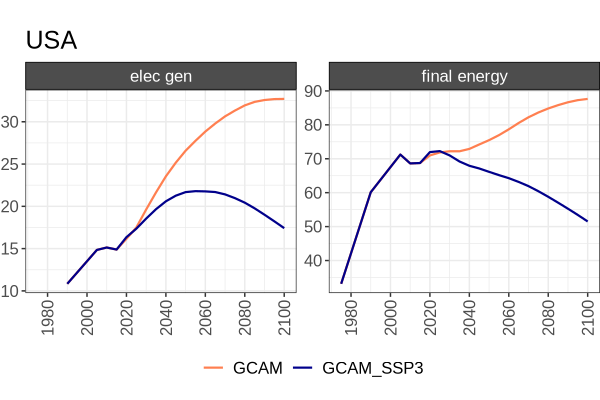

In [24]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 100)
my_charts$chart_param_USA

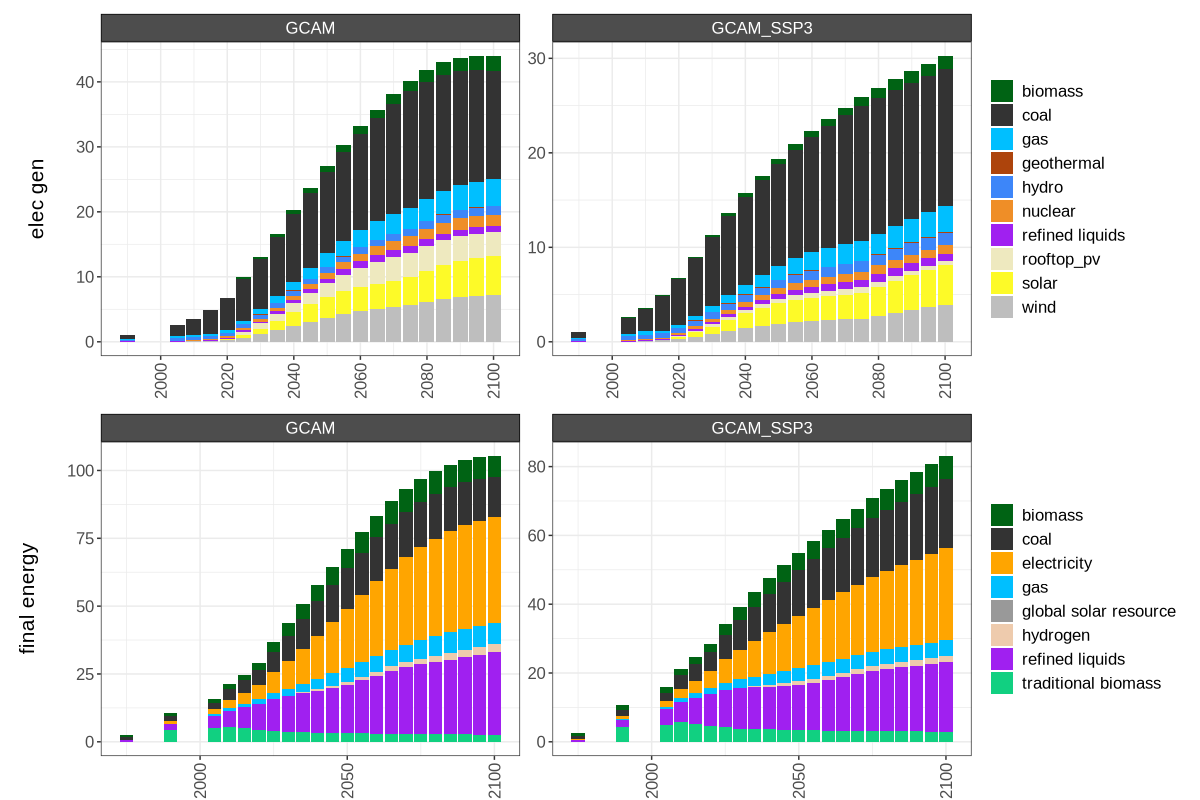

In [25]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 100)
my_charts$chart_class_India

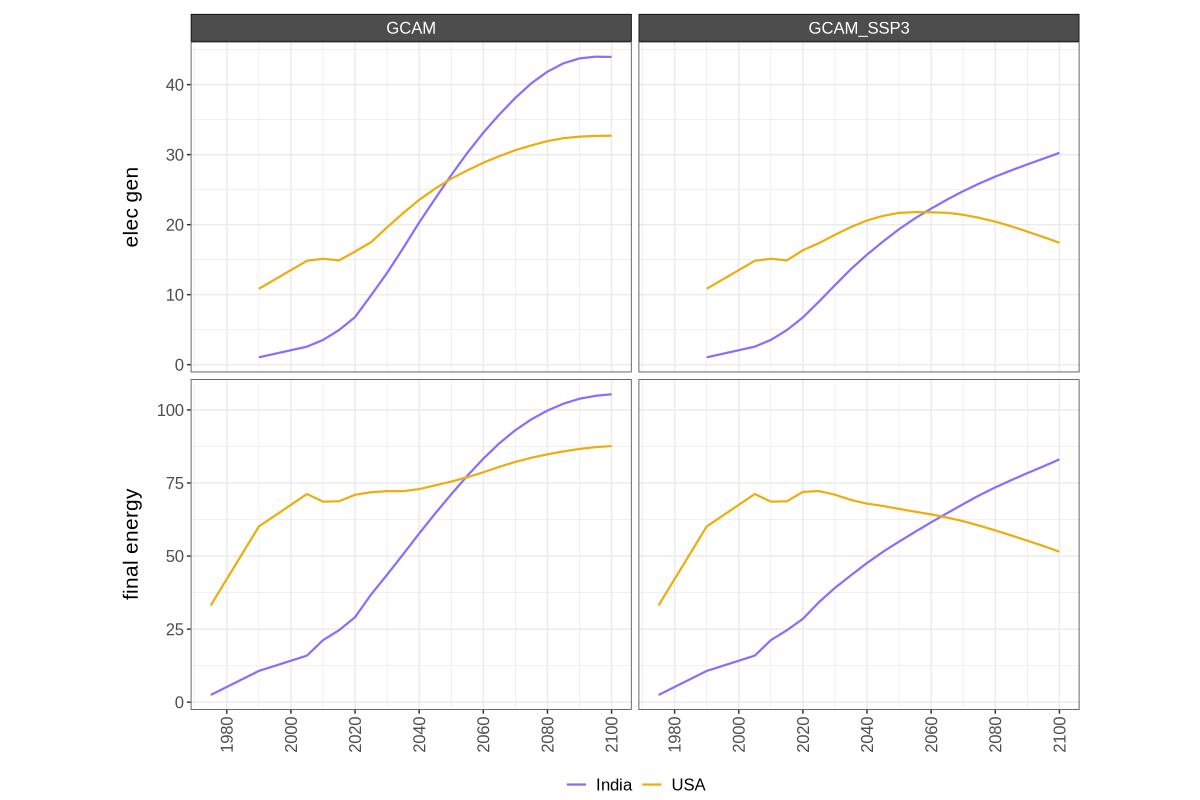

In [26]:
my_charts$chart_region_absolute

### Add summary line to bar charts
The `summary_line` argument can be used to overlay a parameter summary line over bar charts. This is especially useful for barcharts that include both positive and negative values. Setting `summary_line = T` will add summary lines to all bar charts generated, including diff charts.

In [27]:
my_charts <- rchart::chart(data_barcharts, 
                           save = F, 
                           scenRef = "GCAM",
                           summary_line = T,
                           chart_type = "class_diff_absolute")

[1] "Starting chart..."
[1] "Completed chart."


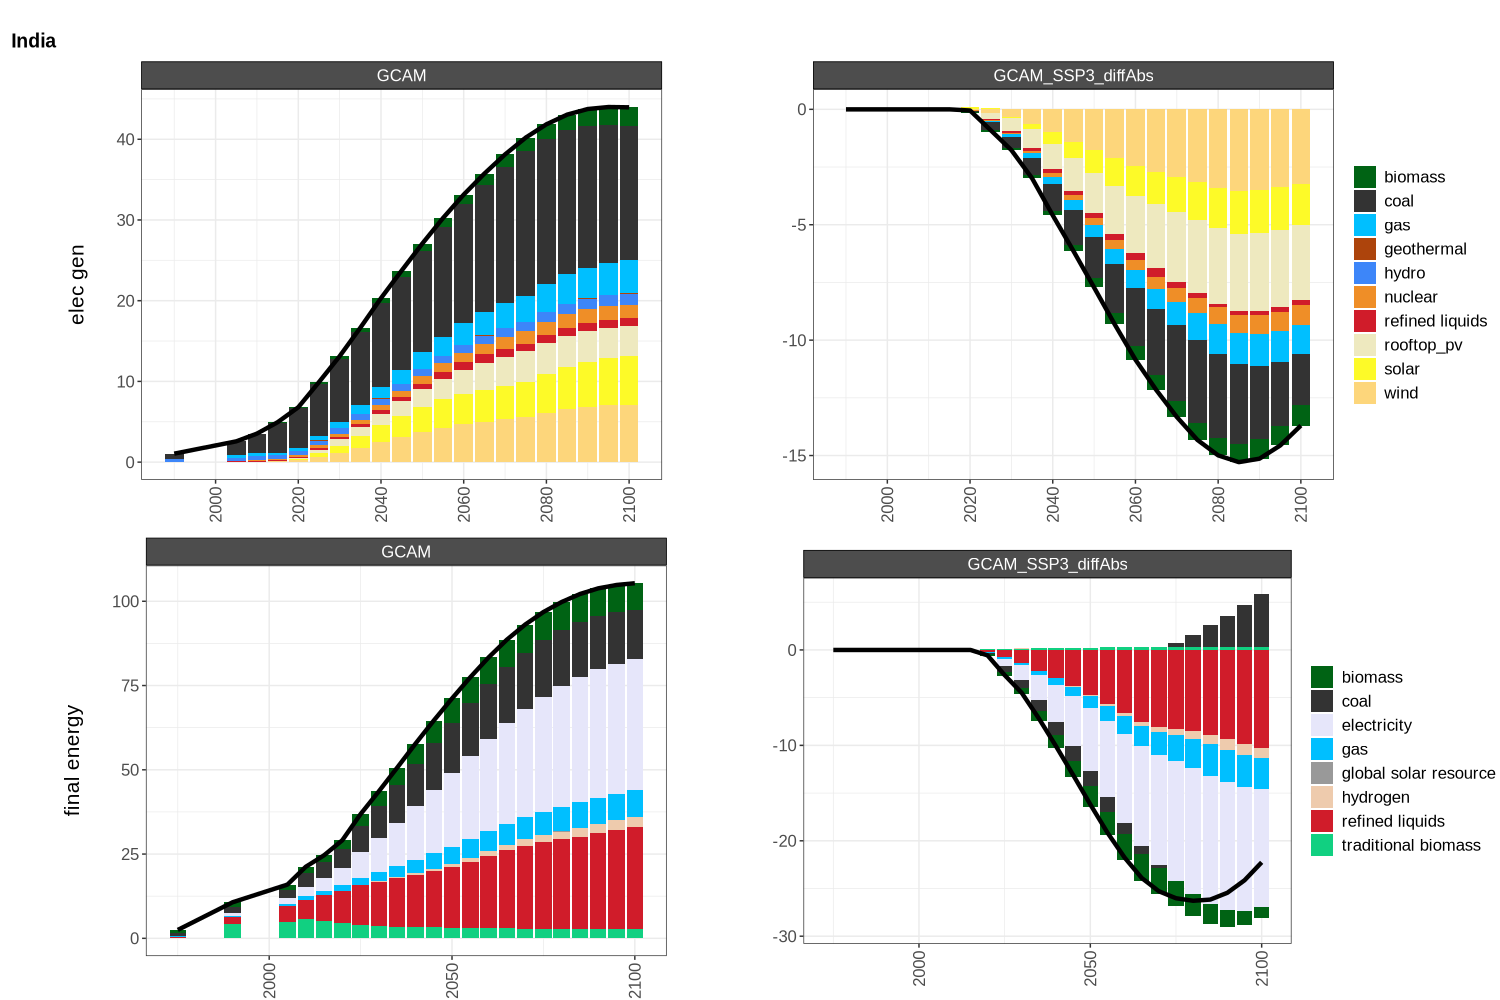

In [28]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
my_charts$chart_class_diff_absolute_India

### Add points to line charts
Points can be added to line charts with the `include_points` argument. The default, `include_points = F` displays only lines for relevant chart types (`chart_param`, `chart_param_diff_absolute`, `chart_param_diff_percent`, `chart_class_diff_percent`, and `plot_region_absolute`), while setting `include_points = T` results in plots with both lines and points for these chart types.

In [29]:
my_chart <- rchart::chart(all_data, 
                          save = F, 
                          include_points = T,
                          chart_type = "param_absolute") 

[1] "Starting chart..."
[1] "Completed chart."


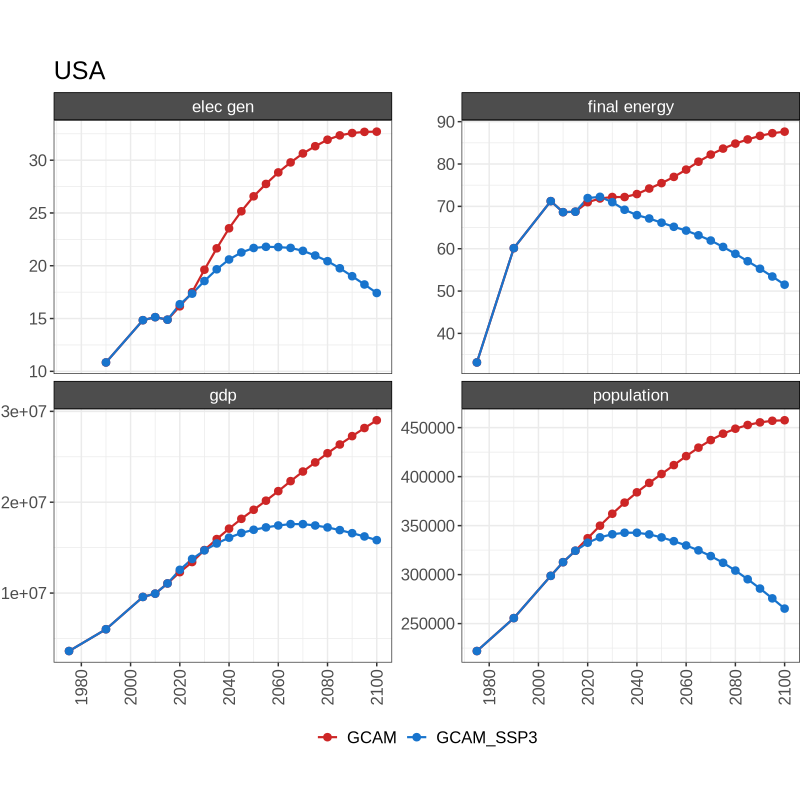

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)
my_chart$chart_param_USA